In [1]:
# Department: ESTSOFT
# Class: AI Modelling
# Category: Machine learning
# Title: Antarctic glacier analysis
# Contributors: Kimm Soo Min
# Last modified date: 13/05/25

# Reference:
# https://github.com/eriklindernoren/PyTorch-GAN
# https://github.com/lucidrains/unet-stylegan2
# https://www.tensorflow.org/tutorials/generative/pix2pix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Library
import numpy as np
import pandas as pd
from pandas import date_range
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import re
from datetime import datetime
import glob
import os
import torch
from torch import nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import save_image
from torch.amp import autocast, GradScaler
from tqdm import tqdm


In [4]:
# Device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = torch.cuda.is_available()

In [5]:
# Dataset for images
class ImageDataset(Dataset):
    def __init__(self, folder, time_step, start_date='1978-11', end_date='2025-04', indices=None):
        self.folder = folder
        self.dates = pd.date_range(start=start_date, end=end_date, freq='MS')
        self.time_step = time_step
        self.indices = indices if indices is not None else range(len(self.dates) - self.time_step)
        self.transform = T.ToTensor() # [0, 255] -> [0, 1]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]

        # Input
        imgs = []
        for j in range(self.time_step):
            date = self.dates[idx + j]
            path = os.path.join(self.folder, f"data/input/image_grey/256x256/img_grey_{date.year}{date.month:02d}.png")
            img = self.transform(Image.open(path))
            imgs.append(img)
        x = torch.cat(imgs, dim=0) # (12, 256, 256)

        # Output
        date = self.dates[idx + self.time_step]
        path = os.path.join(self.folder, f"data/input/image_grey/256x256/img_grey_{date.year}{date.month:02d}.png")
        y = self.transform(Image.open(path)) # (1, 256, 256)

        return x, y

In [6]:
# Generator of GAN
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels=1, features=64):
        super().__init__()

        def block_down(in_channels, out_channels, first=False):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if not first:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def block_up(in_channels, out_channels, last=False):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if not last:
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU())
            else:
                layers.append(nn.Sigmoid())
            return nn.Sequential(*layers)

        self.down_1 = block_down(in_channels, features, first=True) # (12, 256, 256) -> (64, 128, 128)
        self.down_2 = block_down(features, features * 2) # (64, 128, 128) -> (128, 64, 64)
        self.down_3 = block_down(features * 2, features * 4) # (128, 64, 64) -> (256, 32, 32)
        self.down_4 = block_down(features * 4, features * 8) # (256, 32, 32) -> (512, 16, 16)
        self.down_5 = block_down(features * 8, features * 8) # (512, 16, 16) -> (512, 8, 8)
        self.down_6 = block_down(features * 8, features * 8) # (512, 8, 8) -> (512, 4, 4)

        self.up_1 = block_up(features * 8, features * 8) # (512, 4, 4) -> (512, 8, 8)
        self.up_2 = block_up(features * 8 * 2, features * 8) # (1024, 8, 8) -> (512, 16, 16) * Due to concatenation, features doubled
        self.up_3 = block_up(features * 8 * 2, features * 4) # (512, 16, 16) -> (256, 32, 32)
        self.up_4 = block_up(features * 4 * 2, features * 2) # (256, 32, 32) -> (128, 64, 64)
        self.up_5 = block_up(features * 2 * 2, features) # (128, 64, 64) -> (64, 128, 128)
        self.up_6 = block_up(features * 2, out_channels, last=True) # (64, 128, 128) -> (1, 256, 256)

    def forward(self, x):
        # Downsampling
        d_1 = self.down_1(x)
        d_2 = self.down_2(d_1)
        d_3 = self.down_3(d_2)
        d_4 = self.down_4(d_3)
        d_5 = self.down_5(d_4)
        d_6 = self.down_6(d_5)

        # Upsampling w/ skip connections
        u_1 = self.up_1(d_6)
        u_2 = self.up_2(torch.cat([u_1, d_5], dim=1))
        u_3 = self.up_3(torch.cat([u_2, d_4], dim=1))
        u_4 = self.up_4(torch.cat([u_3, d_3], dim=1))
        u_5 = self.up_5(torch.cat([u_4, d_2], dim=1))
        u_6 = self.up_6(torch.cat([u_5, d_1], dim=1))

        return u_6

In [7]:
# Discriminator of GAN
class Discriminator(nn.Module):
    def __init__(self, in_channels, features=64):
        super().__init__()

        def block(in_channels, out_channels, normalise=True, last=False):
            if last:
                return [nn.Conv2d(in_channels, out_channels, kernel_size=4, padding=1)]
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalise:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        self.model = nn.Sequential(*block(in_channels, features, normalise=False), # (13, 256, 256) -> (64, 128, 128)
                                   *block(features, features * 2), # (64, 128, 128) -> (128. 64, 64)
                                   *block(features * 2, features * 4), # (128, 64, 64) -> (256, 32, 32)
                                   *block(features * 4, features * 8), # (256, 32, 32) -> (512, 16, 16)
                                   *block(features * 8, 1, last=True)) # (512, 16, 16) -> (1, 15, 15)

    def forward(self, x, y):
        # Input image x.shape = (B, 12, 256, 256)
        # Target (Real or Generated) image y.shape(B, 1, 256, 256)
        return self.model(torch.cat([x, y], dim=1))

In [8]:
# Path
DIR_PATH = "/content/drive/MyDrive/Class/ESTSOFT/project/antarctic_glacier_analysis"

In [9]:
# Data split
time_step = 60

data_path = os.path.join(DIR_PATH, "data/input/image_grey/256x256")
dataset_full = ImageDataset(data_path, time_step)
n = len(dataset_full)

idx_train = list(range(0, int(n * 0.6)))
idx_val = list(range(int(n * 0.6), int(n * 0.8)))
idx_test = list(range(int(n * 0.8), n))

ds_train = ImageDataset(DIR_PATH, indices=idx_train, time_step=time_step)
ds_val = ImageDataset(DIR_PATH, indices=idx_val, time_step=time_step)
ds_test = ImageDataset(DIR_PATH, indices=idx_test, time_step=time_step)

num_workers = os.cpu_count()
batch_size = 2
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
dl_val   = DataLoader(ds_val, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
dl_test  = DataLoader(ds_test, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

In [10]:
# Instantiation
gen = torch.compile(Generator(in_channels=time_step)).to(device)
dis = torch.compile(Discriminator(in_channels=time_step+1)).to(device)

optimizer_gen = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_dis = torch.optim.Adam(dis.parameters(), lr=2e-4, betas=(0.5, 0.999))

loss_fn_adversarial = nn.BCEWithLogitsLoss() # To fool discriminator
loss_fn_reconstruction = nn.L1Loss() # Be closed to the real image

scaler_gen = GradScaler()
scaler_dis = GradScaler()

/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
# Generator step setting
gen_steps = 4
gen_step_max = 4
gen_step_min = 1
adjust_freq = 5  # Adjust every 5 epochs
threshold = 2.0

# Early stopping setting
loss_val_best = float('inf')
patience = 10
patience_counter = 0

# Training & Validation
losses_train_gen, losses_train_dis, losses_val = [], [], []
epochs = 100
for epoch in range(epochs):
    # Training
    gen.train()
    dis.train()
    loop = tqdm(dl_train)
    loss_train_gen = 0
    loss_train_dis = 0

    for x, y in loop:
        x_train, y_train = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        # Discriminator regulisation by adding Gaussian noise
        noise_real = torch.randn_like(y_train) * 0.05
        noise_fake = torch.randn_like(y_train) * 0.05

        # Discriminator
        with autocast(device_type=device.type):
            y_fake = gen(x_train).detach() # .detach() prevents gradients from flowing back

            # Add noise
            y_real_noisy = y_train + noise_real
            y_fake_noisy = y_fake + noise_fake

            pred_real = dis(x_train, y_real_noisy)
            pred_fake = dis(x_train, y_fake_noisy)

            # Label smoothing
            label_real = torch.full_like(pred_real, 0.9)
            label_fake = torch.zeros_like(pred_fake)

            loss_dis = loss_fn_adversarial(pred_real, label_real) + loss_fn_adversarial(pred_fake, label_fake)

        optimizer_dis.zero_grad()
        scaler_dis.scale(loss_dis).backward()
        scaler_dis.unscale_(optimizer_dis)
        torch.nn.utils.clip_grad_norm_(dis.parameters(), max_norm=1.0)
        scaler_dis.step(optimizer_dis)
        scaler_dis.update()
        loss_train_dis += loss_dis.item()

        # Generator
        for i in range(gen_steps):
            with autocast(device_type=device.type):
                y_fake = gen(x_train)

                pred_fake = dis(x_train, y_fake)

                loss_gen = loss_fn_adversarial(pred_fake, torch.ones_like(pred_fake)) + 100 * loss_fn_reconstruction(y_train, y_fake)

            optimizer_gen.zero_grad()
            scaler_gen.scale(loss_gen).backward()
            scaler_gen.unscale_(optimizer_gen)
            torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=1.0)
            scaler_gen.step(optimizer_gen)
            scaler_gen.update()
            loss_train_gen += loss_gen.item() / gen_steps

        loop.set_description(f"Epoch [{epoch + 1}/{epochs}]")
        loop.set_postfix(loss_d=loss_dis.item(), loss_g=loss_gen.item())

    loss_gen_avg = loss_train_gen / len(dl_train)
    loss_dis_avg = loss_train_dis / len(dl_train)
    losses_train_gen.append(loss_gen_avg)
    losses_train_dis.append(loss_dis_avg)

    # Generator step adjustment
    if (epoch + 1) % adjust_freq == 0:
        ratio = loss_gen_avg / (loss_dis_avg + 1e-8)
        if ratio > threshold and gen_steps < gen_step_max:
            gen_steps += 1
        elif ratio < 1.0 and gen_steps > gen_step_min:
            gen_steps -= 1

    # Validation
    gen.eval()
    loss_val = 0

    with torch.inference_mode():
        for x, y in dl_val:
            x_val, y_val = x.to(device), y.to(device)
            y_pred = gen(x_val)
            loss = loss_fn_reconstruction(y_val, y_pred)
            loss_val += loss.item()

    loss_val_avg = loss_val / len(dl_val)
    losses_val.append(loss_val_avg)

    # Early stopping
    if loss_val_avg < loss_val_best:
        loss_val_best = loss_val_avg
        patience_counter = 0
        torch.save(gen.state_dict(), 'best_gen.pt')
        torch.save(dis.state_dict(), 'best_dis.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

In [ ]:
# Save progress
torch.save({'epoch': epoch,
            'gen_state_dict': gen.state_dict(),
            'dis_state_dict': dis.state_dict(),
            'optimizer_gen_state_dict': optimizer_gen.state_dict(),
            'optimizer_dis_state_dict': optimizer_dis.state_dict(),
            'scaler_gen_state_dict': scaler_gen.state_dict(),
            'scaler_dis_state_dict': scaler_dis.state_dict(),
            'losses_train_gen': losses_train_gen,
            'losses_train_dis': losses_train_dis,
            'losses_val': losses_val,},
           f"{DIR_PATH}/gan_checkpoint.pth")

In [11]:
# Load progress
checkpoint = torch.load(f"{DIR_PATH}/model_checkpoint/gan_v3_checkpoint.pth", map_location=device)

gen.load_state_dict(checkpoint['gen_state_dict'])
dis.load_state_dict(checkpoint['dis_state_dict'])

optimizer_gen.load_state_dict(checkpoint['optimizer_gen_state_dict'])
optimizer_dis.load_state_dict(checkpoint['optimizer_dis_state_dict'])

scaler_gen.load_state_dict(checkpoint['scaler_gen_state_dict'])
scaler_dis.load_state_dict(checkpoint['scaler_dis_state_dict'])

losses_train_gen = checkpoint['losses_train_gen']
losses_train_dis = checkpoint['losses_train_dis']
losses_val = checkpoint['losses_val']

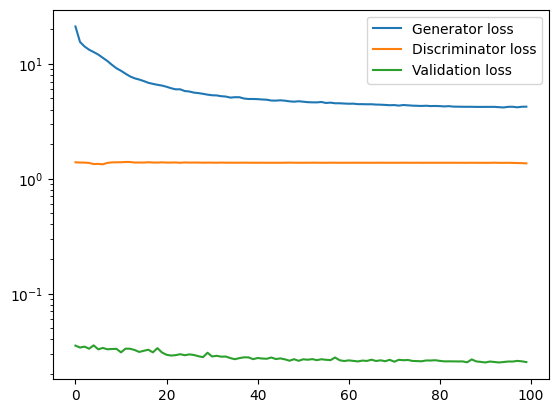

In [12]:
plt.plot(losses_train_gen, label="Generator loss")
plt.plot(losses_train_dis, label="Discriminator loss")
plt.plot(losses_val, label="Validation loss")
plt.yscale('log')
plt.legend()
plt.show()

In [13]:
# Testing - Teacher forcing
gen.eval()
os.makedirs(f"{DIR_PATH}/data/output/gan/image_teaching", exist_ok=True)
img_path = os.path.join(DIR_PATH, "data/output/gan/image_teaching")

with torch.inference_mode():
    for i, (x, y) in enumerate(dl_test):
        x_test, y_test = x.to(device), y.to(device)
        y_pred = gen(x_test)

        for batch in range(batch_size):
            save_image(y_pred[batch].clamp(0, 1), f"{img_path}/pred_{(i * batch_size + batch):02d}.png")
            save_image(y_test[batch].clamp(0, 1), f"{img_path}/true_{(i * batch_size + batch):02d}.png")

        if i == 12:
            break

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [14]:
# Testing - Autoregressive inference
gen.eval()
predictions = []
os.makedirs(f"{DIR_PATH}/data/output/gan//image_autoregressive", exist_ok=True)
img_path = os.path.join(DIR_PATH, "data/output/gan/image_autoregressive")

# Get the first batch
x_test, y_test = next(iter(dl_test))
x_test, y_test = x_test.to(device), y_test.to(device)
x_curr = x_test[0].unsqueeze(0) # (1, 256, 256) -> (1, 1, 256, 256)

steps = 24
with torch.inference_mode():
    for step in range(steps):
        y_pred = gen(x_curr)

        save_image(y_pred[0].clamp(0, 1), f"{img_path}/pred_{step:02d}.png")

        x_curr = torch.cat([x_curr[:, 1:], y_pred], dim=1) # Sliding window